# High speed driving is the significant cause of major accidents

## Context
You work for the road safety team within the department of transport and are looking into how they can reduce the number of major incidents. The safety team classes major incidents as fatal accidents involving 3+ casualties. They are trying to learn more about the characteristics of these major incidents so they can brainstorm interventions that could lower the number of deaths. They have asked for your assistance with answering a number of questions.

## Research questions


1. What time of day and day of the week do most major incidents happen?
2. Are there any patterns in the time of day/ day of the week when major incidents occur?
3. What characteristics stand out in major incidents compared with other accidents?
4. On what areas would you recommend the planning team focus their brainstorming efforts to reduce major incidents?

## Executive summary

-	Most accidents occur between 7:00 AM and 11:00 PM
-	Major accidents are more common on Saturdays, especially at night (7:00 PM to midnight)
-	Due to the COVID-19 lockdown, no major accidents were observed in   April, May, and November
-	The identified hotspots ( at least five accidents with 100m minimum distance) cause no major accidents
-	Speed limit shows the highest association with accident type. Most of the major accidents (~50%) occurred on roads with a speed limit of 60 km/h
-	The majority of high-speed roads are outside of city limits
-	Most major accidents have a higher number (>2) of cars involved
-	Dark conditions may have an impact on the occurrence of a major accident
-	Combining a single-carriageway with a high-speed limit can become a fatal accident zone.
-	Wet/damp conditions can make roads slippery and more prone to major accidents
-	The presence of carriageway hazards on the roads may lead to a major accident


## Introduction


No one in their sane consciousness hops into their car to get involved in a car accident. A car accident can occur at any time, at any place, for many reasons. Car accidents are dangerous not only because of their severe consequences but because it happens so fast, and you must make a split-second decision to avoid them. Not everyone can deal with the tremendous pressure that one faces during an accident.

So, the questions remain, how can we reduce the possibility of experiencing such a situation? How can we prevent it?
There are different approaches and opinions regarding these questions, but I would say improved knowledge about what might increase the risk of a car accident. How can we do that? By analyzing prior car accidents, identifying the common factors involved in these accidents. Then after analyzing these factors, we can rectify these conditions and alert the general population to be cautious when they observe these factors.

Here, we will analyze all the car accidents in the United Kingdom in the year 2020. We will focus our energy on identifying the standard features of major accidents (Fatal accidents with 3+ casualties). Finally, we will recommend possible approaches to reduce the number of major car accidents.


In [ ]:
%%capture
### install required packages and import libaries 

import sys
## install required libaries
!"{sys.executable}" -mpip install shapely
!"{sys.executable}" -mpip install pyproj
!"{sys.executable}" -mpip install geopandas
!"{sys.executable}" -m pip install folium
!"{sys.executable}" -m pip install researchpy
!"{sys.executable}" -m pip install phik

### import libaries

import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.dates as md

from datetime import datetime
import seaborn as sns
from collections import Counter
import math
from sklearn.cluster import DBSCAN
from shapely.geometry import Point
from functools import partial
from shapely.ops import transform
from shapely.ops import unary_union
import pyproj
import geopandas as gpd
import folium

import scipy.stats as ss
from collections import Counter
import researchpy as rp
import itertools
import phik
from phik.report import plot_correlation_matrix




%matplotlib inline
# from matplotlib.gridspec import GridSpec

### set seed
random.seed(1169)

# ### set context and palette for seaborn
# sns.set_context('talk')
# sns.set_palette('colorblind')


# plt.rcParams["figure.figsize"] = [15,6]
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

## 💾 The data

The reporting department has been collecting data on every accident that is reported. They've included this along with a lookup file for 2020's accidents.

Published by the department for transport. https://data.gov.uk/dataset/road-accidents-safety-data Contains public sector information licensed under the Open Government Licence v3.0.

The dataset mainly contains pertinent information regarding each accident in the U.K. in the year 2020. Most of the features of this dataset are nominal variables. We have assigned appropriate column types to each feature and created a __label__ column that identifies each accident as major or minor type accidents. The __major__ kind of accidents is those which were fatal with 3+ casualties. All other accidents were classified as __minor__ accidents.


In [ ]:
## data processing

lookup = pd.read_csv(r'./data/road-safety-lookups.csv')

accidents = pd.read_csv(r'./data/accident-data.csv')
## as most of the columns contain codes for different categorical variables, these columns need to converted into objact class 
object_list =['accident_severity',
              'first_road_class',
              'road_type',
              'speed_limit',
              'junction_detail',
              'junction_control',
              'second_road_class',
              'pedestrian_crossing_human_control',
              'pedestrian_crossing_physical_facilities',
              'light_conditions','weather_conditions',
              'road_surface_conditions',
              'special_conditions_at_site',
              'carriageway_hazards',
              'urban_or_rural_area']

accidents[object_list] = accidents[object_list].astype('object')
 
## created 'date_time' column as 'datetime64[ns]' type for further ease of calculations
accidents['date_time']= pd.to_datetime(accidents['date']+' '+accidents['time'], format = '%d/%m/%Y %H:%M')

## created an accident hour time column
accidents['hour'] = accidents.loc[:,'date_time'].dt.hour

## created a cloumn titled 'label' to assign accident type 'major' or 'minor' to each incident. 
## incidents with 'accident severity' class 'fatal'(=1) and atleast  3 as 'number of casualties' are considered 'major' class
## all other incidents are labeled as minor class.
major_or_minor=(accidents['accident_severity']==1) & (accidents['number_of_casualties']>=3)

accidents['label']= np.where(major_or_minor,'major','minor')

## remove redundent columns
drop_list =['accident_year', 'accident_reference', 'date', 'time']

accidents.drop(drop_list,axis=1, inplace=True)
accidents.head()



,accident_index,longitude,latitude,accident_severity,number_of_vehicles,number_of_casualties,day_of_week,first_road_class,first_road_number,road_type,speed_limit,junction_detail,junction_control,second_road_class,second_road_number,pedestrian_crossing_human_control,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,date_time,hour,label
0,2020010219808,-0.254001,51.462262,3,1,1,3,6,0,6,20,0,-1,6,0,9,9,1,9,9,0,0,1,2020-02-04 09:00:00,9,minor
1,2020010220496,-0.139253,51.470327,3,1,2,2,3,3036,6,20,9,2,6,0,0,4,1,1,1,0,0,1,2020-04-27 13:55:00,13,minor
2,2020010228005,-0.178719,51.529614,3,1,1,4,5,0,6,30,3,1,6,0,0,0,4,1,2,0,0,1,2020-01-01 01:25:00,1,minor
3,2020010228006,-0.001683,51.541210,2,1,1,4,3,11,6,30,0,-1,6,0,0,4,4,1,1,0,0,1,2020-01-01 01:50:00,1,minor
4,2020010228011,-0.137592,51.515704,3,1,2,4,3,40,6,30,3,4,5,0,0,0,4,1,1,0,0,1,2020-01-01 02:25:00,2,minor


### Handling missing values

In [ ]:
accidents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91199 entries, 0 to 91198
Data columns (total 26 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   accident_index                           91199 non-null  object        
 1   longitude                                91185 non-null  float64       
 2   latitude                                 91185 non-null  float64       
 3   accident_severity                        91199 non-null  object        
 4   number_of_vehicles                       91199 non-null  int64         
 5   number_of_casualties                     91199 non-null  int64         
 6   day_of_week                              91199 non-null  int64         
 7   first_road_class                         91199 non-null  object        
 8   first_road_number                        91199 non-null  int64         
 9   road_type                              

The provided data has __no null values__. However, some columns have a special code (-1) for missing values or out-of-range conditions. If necessary, we will carefully consider them when we conduct analysis.

## Analysis Plan

This project aims to identify timeline patterns and typical characteristics of major accidents. To achieve these objectives, we will conduct the following analysis steps:
- Exploratory data analysis -- to determine the timeline pattern of major accidents
- Density-based spatial clustering of applications with noise (DBSCAN). -- to identify accident hotspots based on geospatial coordinates of the accidents. And to identify if there is any relationship between accident hotspots and major accidents.
- Pearson Chi-square test
- Cramér's V analysis
- Theil's U (uncertainty coefficient) analysis
The last three approaches will be used to identify the most influencing features associated with major accidents. We want to mention that, Pearson Chi-square test is applied to sets of categorical data to evaluate how likely it is that any observed difference between the sets arose by chance. This test only reveals any significant relationship between the two features. The Chi-square test can not measure the level of association between two features.

Cramér's V approach is based on the Chi-squared test, and it provides a measure of association between two nominal variables. But the drawback of Cramér's V approach is that it can identify the causative feature between features; it considers a both-way relationship.

Teil's U is also a measure of nominal association. The major advantage of this approach is that it measures association in one way(cause to effect).

Finally, we will utilize a new approach based on a paper published in 2020. The authors introduced a new correlation coefficient, φK (phik), which works consistently between categorical, ordinal, and interval variables and can capture nonlinear dependency. Another exciting aspect of this approach is that it measures the relationship significance between each category between two features. The link to this article is as below: https://www.sciencedirect.com/science/article/abs/pii/S0167947320301341

We will compare feature importance among all the approaches and make a holistic decision regarding the typical characteristics of significant accidents in comparison to other accidents.



## Exploratory Data Analysis (EDA)



#### Distribution of accident types

In the year 2020, there were a total of 91199 motor vehicle accidents in
the United Kingdom.




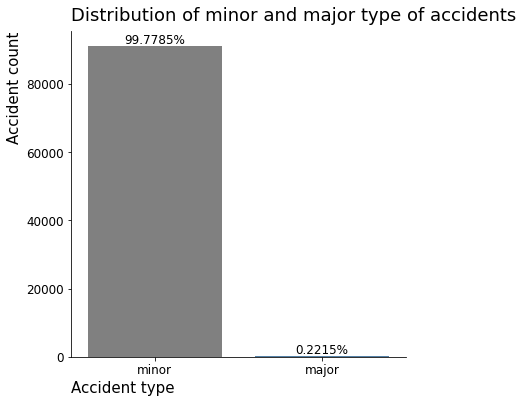



Among these accidents,
1. 90997 accidents (99.7785%) were classified as minor accidents
2. 202 accidents (0.2215%) were classified as major accidents


In [ ]:
total_accidents= accidents.shape[0]

print('In the year 2020, there were a total of {} motor vehicle accidents in\nthe United Kingdom.'.format(total_accidents))
print('\n')

fig, ax = plt.subplots(figsize=(6,6))

# sns.set_context("paper") 

accident_type= pd.DataFrame(accidents['label'].value_counts()).reset_index()
accident_type.columns =['accident type' ,'accident count']
accident_type['percentage']=(accident_type['accident count']/accident_type['accident count'].sum())*100

colors =['grey','steelblue']
ax = sns.barplot(y="accident count",x='accident type', data=accident_type, palette=colors)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.4f}%'.format((p.get_height()/total_accidents)*100), (x.mean(), y), 
            ha='center', va='bottom', size=12)

plt.title('Distribution of minor and major type of accidents', fontdict={'fontsize' : 18}, loc='left', pad=10)
plt.xlabel('Accident type',fontsize=15,loc='left')
plt.ylabel('Accident count',fontsize=15, loc='top')

ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)

sns.despine()
plt.show()

print('\n')
print('Among these accidents,')

for i in accident_type.index:
    print('{}. {} accidents ({:.4f}%) were classified as {} accidents'.format(i+1 ,accident_type['accident count'][i], accident_type['percentage'][i], accident_type['accident type'][i]))




In [ ]:
## as we are going to work with major accidents only, it is better to subset the dataframe based on accident type(label).

major =  accidents[accidents['label']=='major']
minor = accidents[accidents['label']=='minor']

#### Time distribution of accidents

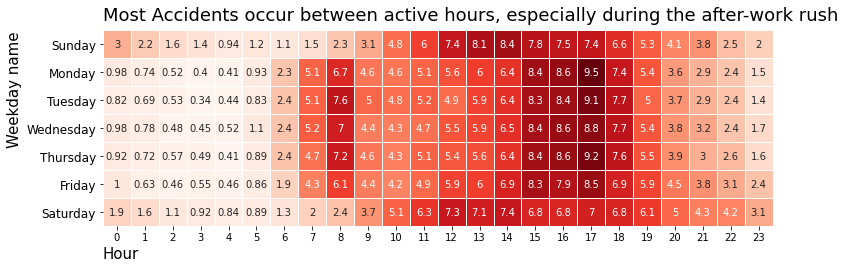

In [ ]:
kk=pd.crosstab(accidents.day_of_week,accidents['date_time'].dt.hour, normalize='index')*100
fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(kk, 
            cmap='Reds',
            annot=True, 
            linewidths=1, 
            square=True,
           cbar=False)

dayname_list = lookup[lookup['field name']=='day_of_week']['label'].to_list()
plt.title('Most Accidents occur between active hours, especially during the after-work rush', fontdict={'fontsize' : 18}, loc='left', pad=10)
ax.set_yticklabels(dayname_list,rotation = 0, size=12,ha='right')
ax.set_ylabel('Weekday name',fontsize=15,loc='top')
ax.set_xlabel('Hour',fontsize=15,loc='left')
plt.show()

According to the above graph, most accidents (percentage count by hour per weekday) occur between __7:00 AM__ and __11:00 PM__. This phenomenon is expected, as this time range experiences most traffic due to active hours. If we dig down a little bit more, we can see that, on working days, most accidents occur when people are returning from work(3:00 PM to 7:00 PM). Usually, people are tired and probably more prone to make mistakes while driving this time. And on weekends, this distribution is more spread over.

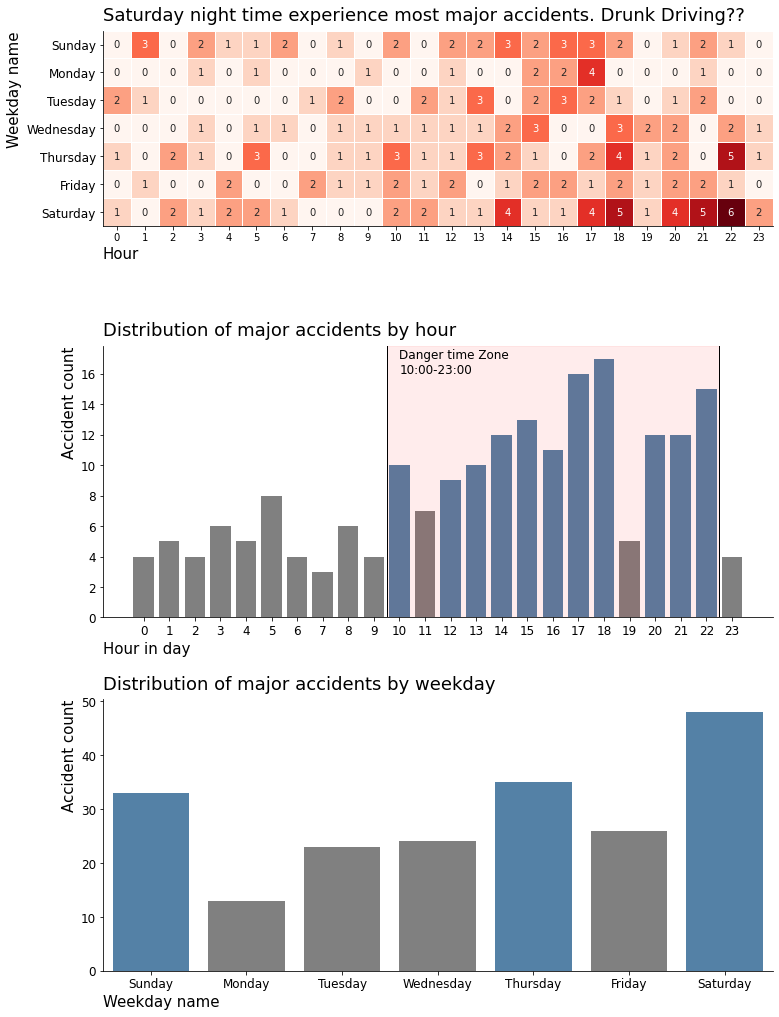

In [ ]:
## by hour -- time of day

fig, ax = plt.subplots(3,1,figsize=(12,18))
weekday_hour=pd.crosstab(major.day_of_week,major['date_time'].dt.hour)#*100

sns.heatmap(weekday_hour, 
            cmap='Reds',
            annot=True, 
            linewidths=1, 
            square=True,
           cbar=False,
            ax=ax[0])

dayname_list = lookup[lookup['field name']=='day_of_week']['label'].to_list()
ax[0].set_title('Saturday night time experience most major accidents. Drunk Driving??', fontdict={'fontsize' : 18}, loc='left', pad=10)
ax[0].set_yticklabels(dayname_list,rotation = 0, size=12,ha='right')
ax[0].set_yticklabels(dayname_list,rotation = 0, size=12,ha='right')
ax[0].set_ylabel('Weekday name',fontsize=15,loc='top')
ax[0].set_xlabel('Hour',fontsize=15,loc='left')

##________________________________________________________________

# sns.set_context("paper") 
major =  accidents[accidents['label']=='major']
hour_distribution=major.groupby([major['hour']])['accident_index'].agg(['count'])
hour_distribution['percentage']=hour_distribution.apply(lambda x: x/x.sum())

clrs = ['grey' if (x < (np.partition(hour_distribution['count'], -11)[-11])) else 'steelblue' for x in hour_distribution['count'] ]

ax[1] = sns.barplot(y='count',x=hour_distribution.index, data=hour_distribution, palette=clrs, ax=ax[1])
ax[1].axvline(x=9.5, color='k', lw=1)
ax[1].axvline(x=22.5, color='k', lw=1)
ax[1].axvspan(9.5, 22.5, alpha=0.075, color='r')
ax[1].text(s='Danger time Zone \n10:00-23:00', x=10, y=16, color = 'k',fontsize=12)
ax[1].set_title('Distribution of major accidents by hour', fontdict={'fontsize' : 18}, loc='left', pad=10)
ax[1].set_xlabel('Hour in day',fontsize=15,loc='left')
ax[1].set_ylabel('Accident count',fontsize=15,loc='top')

ax[1].tick_params(axis='both', which='major', labelsize=12)
# ax.tick_params(axis='both', which='minor', labelsize=12)

##____________________________________________________________________________________

per_day_acci_count =major['day_of_week'].value_counts(sort=False).sort_index()
clrs_0 = ['grey' if (x < (np.partition(per_day_acci_count, -3)[-3])) else 'steelblue' for x in per_day_acci_count ]
sns.countplot(x='day_of_week', data=major, palette=clrs_0, ax=ax[2])
dayname_list = lookup[lookup['field name']=='day_of_week']['label'].to_list()

ax[2].set_xticklabels(dayname_list)
ax[2].set_title('Distribution of major accidents by weekday', fontdict={'fontsize' : 18}, loc='left', pad=10)
ax[2].set_xlabel('Weekday name',fontsize=15,loc='left')
ax[2].set_ylabel('Accident count',fontsize=15,loc='top')
ax[2].tick_params(axis='x', labelsize=12)
ax[2].tick_params(axis='y', labelsize=12)

plt.subplots_adjust(hspace = 0.3)
sns.despine()
plt.show()

When we account for major accidents only, we observe that major accidents are more common on Saturdays, especially at night (__7:00 PM to midnight__). One possible reason may be that drunk people are causing more major accidents during this period.

Also, we can observe that majority of major accidents occur between 10:00 AM to midnight. And rank-wise, Saturday, Thursday, and Sunday had most accidents.

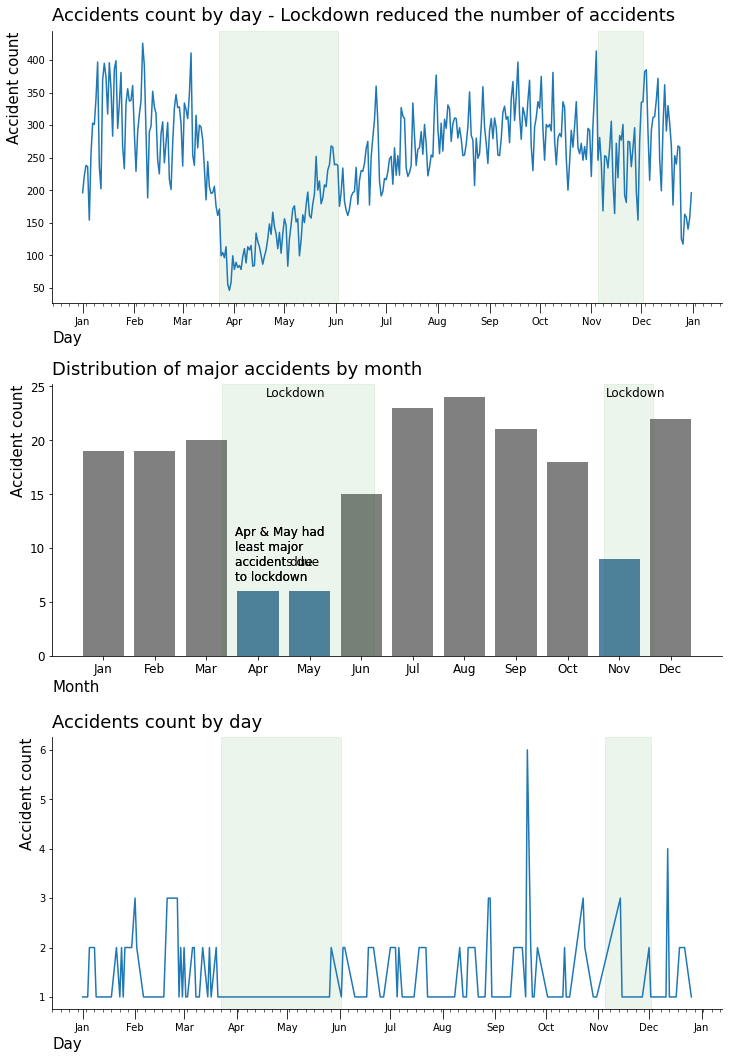

In [ ]:

fig, ax = plt.subplots(3,1, figsize=(12,18))

data = pd.DataFrame(accidents['date_time'].dt.date.value_counts()).reset_index()
sns.lineplot(x='index' , y='date_time', data=data, ax=ax[0]) 

ax[0].set_title('Accidents count by day - Lockdown reduced the number of accidents', fontdict={'fontsize' : 18}, loc='left', pad=10)
# specify the position of the major ticks at the beginning of the month
ax[0].xaxis.set_major_locator(md.MonthLocator())
# specify the format of the labels as 'month'
ax[0].xaxis.set_major_formatter(md.DateFormatter('%b'))
# (optional) rotate by 90° the labels in order to improve their spacing
plt.setp(ax[0].xaxis.get_majorticklabels(), rotation = 0)

# specify the position of the minor ticks at each 5 day
ax[0].xaxis.set_minor_locator(md.DayLocator(interval = 5))

# set ticks length
ax[0].tick_params(axis = 'x', which = 'major', length = 10)
ax[0].tick_params(axis = 'x', which = 'minor', length = 3)
# ax[0].set_xlim(xmin=datetime.strptime('2019/12/31', '%Y/%m/%d'))
ax[0].axvspan(datetime.strptime('2020/03/23', '%Y/%m/%d'), datetime.strptime('2020/06/2', '%Y/%m/%d'), alpha=0.075, color='green')
ax[0].axvspan(datetime.strptime('2020/11/05', '%Y/%m/%d'), datetime.strptime('2020/12/02', '%Y/%m/%d'), alpha=0.075, color='green')

ax[0].set_xlabel('Day',fontsize=15,loc='left')
ax[0].set_ylabel('Accident count',fontsize=15,loc='top')

#___________________________________

per_month_accid_count = major.groupby([major['date_time'].dt.month])['accident_index'].agg(['count'])['count'].to_list()
# clrs_1 = ['grey' if x> min(per_quarter_accid_count) else 'mediumseagreen' for x in per_month_accid_count ]
clrs_1=['grey' if (x > (np.partition(per_month_accid_count, 2)[2])) else 'steelblue' for x in per_month_accid_count ]


sns.countplot(x=major['date_time'].dt.month, data=major, palette=clrs_1, ax=ax[1])
month_list =['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'] 

ax[1].set_xticklabels(month_list)
ax[1].set_title('Distribution of major accidents by month', fontdict={'fontsize' : 18}, loc='left', pad=10)
ax[1].text(s='Lockdown', x=3.15, y=24, color = 'k',fontsize=12)
ax[1].text(s='Apr & May had\nleast major\naccident due\nto lockdown', x=2.56, y=7, color = 'k',fontsize=12)

ax[1].text(s='Lockdown', x=9.75, y=24, color = 'k',fontsize=12)
ax[1].text(s='Apr & May had\nleast major\naccidents due\nto lockdown', x=2.56, y=7, color = 'k',fontsize=12)

ax[1].axvspan(2.3, 5.25, alpha=0.075, color='green')
ax[1].axvspan(9.7, 10.65, alpha=0.075, color='green')
ax[1].set_xlabel('Month',fontsize=15,loc='left')
ax[1].set_ylabel('Accident count',fontsize=15,loc='top')
ax[1].tick_params(axis='both', labelsize=12)
# ax[1].set_xlim(xmin=-0.5)


#_________________________________________________________________________________

data = pd.DataFrame(major['date_time'].dt.date.value_counts()).reset_index()
sns.lineplot(x='index' , y='date_time', data=data, ax=ax[2]) 

ax[2].set_title('Accidents count by day', fontdict={'fontsize' : 18}, loc='left', pad=10)
# specify the position of the major ticks at the beginning of the month
ax[2].xaxis.set_major_locator(md.MonthLocator())
# specify the format of the labels as 'month'
ax[2].xaxis.set_major_formatter(md.DateFormatter('%b'))
# (optional) rotate by 90° the labels in order to improve their spacing
plt.setp(ax[2].xaxis.get_majorticklabels(), rotation = 0)

# specify the position of the minor ticks at each 5 day
ax[2].xaxis.set_minor_locator(md.DayLocator(interval = 5))

# set ticks length
ax[2].tick_params(axis = 'x', which = 'major', length = 10)
ax[2].tick_params(axis = 'x', which = 'minor', length = 3)
# ax[0].set_xlim(xmin=datetime.strptime('2019/12/31', '%Y/%m/%d'))
ax[2].axvspan(datetime.strptime('2020/03/23', '%Y/%m/%d'), datetime.strptime('2020/06/2', '%Y/%m/%d'), alpha=0.075, color='green')
ax[2].axvspan(datetime.strptime('2020/11/05', '%Y/%m/%d'), datetime.strptime('2020/12/02', '%Y/%m/%d'), alpha=0.075, color='green')

ax[2].set_xlabel('Day',fontsize=15,loc='left')
ax[2].set_ylabel('Accident count',fontsize=15,loc='top')


plt.subplots_adjust(hspace = 0.3)
sns.despine()
plt.show()

The least number of significant accidents occurred in the months of __April, May, and November__. This kind of observation is expected as the U.K. were under lockdown due to __COVID-19__ restriction during these months. There was very little traffic and no major accidents at all. Also, it is nearly impossible to deduce any month-based relationship because we have access to only one year's data. Access to historical data and further analysis may identify relevant trends in the occurrence of accidents.

## DBSCAN analysis

In this section of the report, we tried to cluster geolocation of accidents to identify accident hot spots around the United Kingdom. We identified a hotspot where more than five accidents occurred with a 100-meter minimum distance between each other. Then we tried to plot the location of major accidents on the map to identify if any major accidents location belonged to these hotspots.
 

In [ ]:
# Drop invalid rows
accidents.dropna()

accidents = accidents.loc[accidents.latitude <=  90.0]
accidents = accidents.loc[accidents.latitude >= -90.0]

accidents = accidents.loc[accidents.longitude <=  180.0]
accidents = accidents.loc[accidents.longitude >= -180.0]

accidents['rad_lng'] = accidents['longitude'] * math.pi / 180.0
accidents['rad_lat'] = accidents['latitude'] * math.pi / 180.0

In [ ]:
# Cluster the data
# Parameters
eps_in_meters = 100.0
num_samples = 5

earth_perimeter = 40070000.0  # In meters
eps_in_radians = eps_in_meters / earth_perimeter * (2 * math.pi)

accidents['cluster'] = DBSCAN(eps=eps_in_radians, min_samples=num_samples, metric='haversine').fit_predict(accidents[['rad_lat', 'rad_lng']])


groups = accidents.groupby('cluster')

In [ ]:
# Create the list of cluster blobs
def buffer_in_meters(lng, lat, radius):
    wgs84 = pyproj.CRS('EPSG:4326')
    utm = pyproj.CRS('EPSG:32618')

    
    project_to_meters = pyproj.Transformer.from_crs(wgs84, utm, always_xy=True).transform
    project_to_latlng = pyproj.Transformer.from_crs(utm, wgs84, always_xy=True).transform
    pt_latlng = Point(lng, lat)
    
    pt_meters = transform(project_to_meters, pt_latlng)

    
    buffer_meters = pt_meters.buffer(radius)
    buffer_latlng = transform(project_to_latlng, buffer_meters)
    return buffer_latlng



clusters = list()
blobs = list()
counts = list()

for cluster_id, points in groups:
    if cluster_id >= 0:
        buffer_radius = eps_in_meters #* 0.6
        buffers = [buffer_in_meters(lon, lat, buffer_radius) for lon, lat in zip(points['longitude'], points['latitude'])]
        blob = unary_union(buffers)
        blobs.append(blob)
        clusters.append(cluster_id)
        counts.append(len(points))
        
# Create the GeoDataFrame from the cluster numbers and blobs
data = { 'cluster': clusters, 'polygon': blobs, 'count': counts }


cluster_gdf = gpd.GeoDataFrame(pd.DataFrame(data), geometry='polygon')
cluster_gdf = cluster_gdf.set_crs(epsg=4326)

In [ ]:
%%capture  

m = folium.Map(location=[51.5, -0.0], zoom_start=10, tiles='CartoDB positron')
major_acc_loc=accidents[accidents.label =='major'][['longitude','latitude']]
minor_acc_loc=accidents[accidents.label =='minor'][['longitude','latitude']]

for _, r in cluster_gdf.iterrows():
    # Without simplifying the representation of each borough,
    # the map might not be displayed
    sim_geo = gpd.GeoSeries(r['polygon']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'red'})
    folium.Popup('Hotspot#: {}, count:{}'.format(r['cluster'], r['count'])).add_to(geo_j)
    geo_j.add_to(m)
    
major_acc_loc.apply(lambda row:folium.CircleMarker(location=[row["latitude"], row["longitude"]], 
                                              radius=1, color='red')
                                             .add_to(m), axis=1)

minor_acc_loc.apply(lambda row:folium.CircleMarker(location=[row["latitude"], row["longitude"]], 
                                              radius=1, color='grey')
                                             .add_to(m), axis=1) ### was not applied on first image, only applied on the second image

m

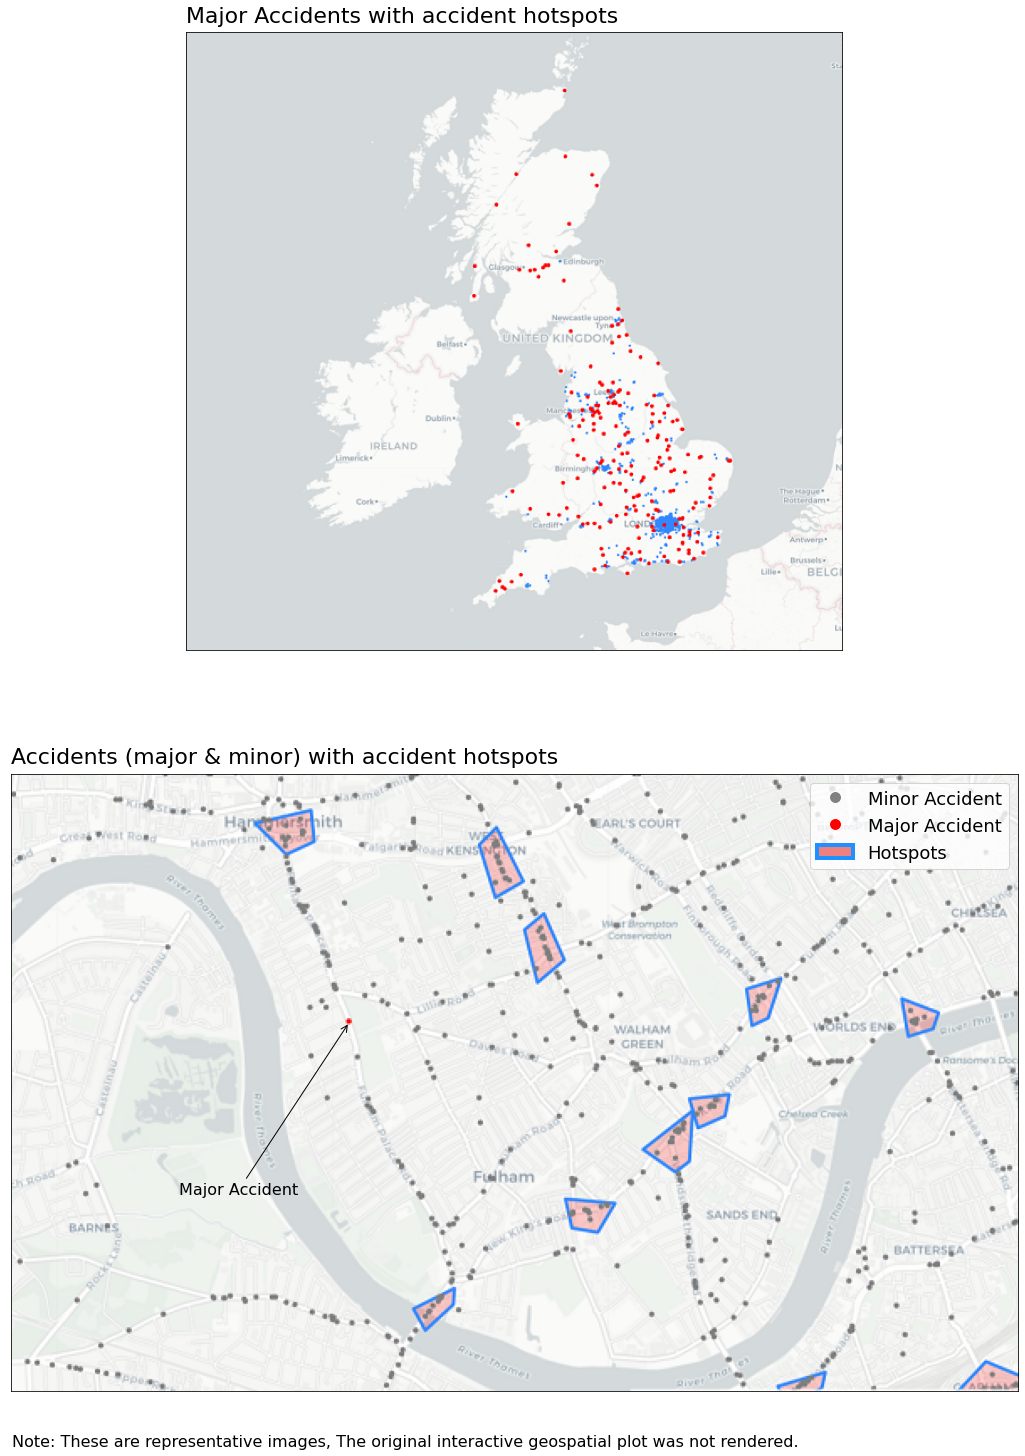

In [ ]:

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Minor Accident',
                          markerfacecolor='grey', markersize=12),
                   Line2D([0], [0], marker='o', color='w', label='Major Accident',
                          markerfacecolor='r', markersize=12),
                   Patch(facecolor='lightcoral', edgecolor='dodgerblue', linewidth=4,
                         label='Hotspots')]


# figure size in inches optional
rcParams['figure.figsize'] = 25 ,25

# read images
img_A = mpimg.imread('./images/eng.png')
img_B = mpimg.imread('./images/eng3.png')

# display images
fig, ax = plt.subplots(2,1)
ax[0].imshow(img_A)
ax[0].set_title('Major Accidents with accident hotspots',fontdict={'fontsize' : 22}, loc='left', pad=10)
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)
#_____________________________________________
ax[1].imshow(img_B)
ax[1].set_title('Accidents (major & minor) with accident hotspots',fontdict={'fontsize' : 22}, loc='left', pad=10)
ax[1].legend(handles=legend_elements, prop={'size': 18})
ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)
ax[1].annotate('Major Accident', xy=(201,148), xytext=(100,250),arrowprops=dict(arrowstyle='->',lw=1), fontsize=16)

ax[1].text(0,400, "Note: These are representative images, The original interactive geospatial plot was not rendered.", fontsize=16)

plt.show()

The red and grey dots on the map identify the location of major and minor accidents, respectively. The blue-bordered polygons are the hotspots.


In [ ]:
major_acc_loc=accidents[accidents.label =='major'][['longitude','latitude']]
major_gdf = gpd.GeoDataFrame(
    major_acc_loc, geometry=gpd.points_from_xy(major_acc_loc.longitude, major_acc_loc.latitude))

point_in_polygon = []
count=0

for point in major_gdf['geometry']:
    for polygon in cluster_gdf['polygon']:
        if (point.within(polygon)) | (polygon.touches(point)):
            point_in_polygon.append([point,polygon])
            count=+1
            
print('Total {} major accident(s) fall into the area of accident hotspots'.format(count))

Total 0 major accident(s) fall into the area of accident hotspots


Our analysis shows that none of the major accidents are caused by the identified hotspots. To get expected results, we may need to increase the minimum distance or reduce the number of accidents to redefine the hotspots.

Also, we will like to mention that it is challenging to identify any geospatial relationship due to a very high imbalance between the major and minor types of accidents. Even further upsampling will not help as it will skew the data to an end. We will exclude geospatial-related feature columns from further analysis.

In [ ]:
accidents.drop(['rad_lng','longitude', 'latitude','rad_lat', 'cluster'], axis=1, inplace=True)

## Analysis -- Identifying common features of major accidents

We will drop 'accident_index','first_road_number' & 'second_road_number' as they are unique identifier or related geospatial position.

We will also drop 'accident_severity' and 'number_of_casualties' columns as they were directly used to generate the label(major/minor) feature. These features will directly translate into our label column and correlate highly with the outcome. This phenomenon is an example of information leakage.

Additionally, as 'day_of_week,' 'number_of_vehicles,' and 'hour' features are discrete ordinal variables with limited range, we will consider them categorical variables.



In [ ]:
columns_to_drop =['accident_index',  'accident_severity',
        'number_of_casualties', 'first_road_number','second_road_number']

accidents.drop(columns_to_drop, axis=1, inplace=True)
accidents[['day_of_week_c', 'number_of_vehicles_c']] = accidents[['day_of_week', 'number_of_vehicles']].astype('object')

cat_features=accidents.select_dtypes(["object", "category"]).columns.drop(['label'])

In [ ]:
results = {}
# cat_features = [col for col in accidents_m.select_dtypes(["object", "category"]).columns if col != "label"]

def conditional_entropy(x,y):
    # entropy of x given y
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy

def theil_u(x,y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

for feature in cat_features:
    crosstab, test_results, expected = rp.crosstab(accidents["label"], accidents[feature],
                                               test= "chi-square",
                                               expected_freqs= True,
                                               prop= "cell")
    chi_significance = (test_results.iloc[1,1]<=0.05)
    ###________________________________________________________
    theil_u_v=theil_u(accidents["label"], accidents[feature])
    ##________________________________________________________
    x, y = accidents[['label', feature]].T.values
    phik_value = phik.phik_from_array(x, y)
    phik_significance = phik.significance_from_array(x, y)[1]
    ##________________________________________________________
    results.update({feature: {"Pearson Chi-square ( 6.0)": test_results.iloc[0,1], "p-value": test_results.iloc[1,1],"Chi-square significance": chi_significance,"Cramer's V":test_results.iloc[2,1], 'theil_u':theil_u_v, "phik": phik_value, "phik_significance": phik_significance}})

print("The chi-squared test results of the categorical features (sorted by phik_significance and theil_u value in descending order):\n")
result_df = pd.DataFrame(results).transpose()
# chi2_df["Chi-square significance"] = np.where(chi2_df['p-value']<= 0.05, True, False)
result_df = result_df.sort_values(by=["phik_significance",'theil_u'], ascending=[False, False])
result_df

The chi-squared test results of the categorical features (sorted by phik_significance and theil_u value in descending order):



,Pearson Chi-square ( 6.0),p-value,Chi-square significance,Cramer's V,theil_u,phik,phik_significance
speed_limit,283.5359,0.0,True,0.0558,0.081665,0.051551,14.598683
urban_or_rural_area,174.7815,0.0,True,0.0438,0.055915,0.068129,12.577635
number_of_vehicles_c,436.4343,0.0,True,0.0692,0.040349,0.073314,9.728277
light_conditions,119.9794,0.0,True,0.0363,0.02643,0.049369,7.834923
junction_control,65.776,0.0,True,0.0269,0.025982,0.035893,7.567911
junction_detail,67.8685,0.0,True,0.0273,0.026414,0.026309,6.94341
pedestrian_crossing_physical_facilities,41.2776,0.0,True,0.0213,0.021176,0.025834,6.376846
first_road_class,43.237,0.0,True,0.0218,0.015835,0.028471,5.553099
day_of_week_c,33.0553,0.0,True,0.019,0.011138,0.016096,4.177948
road_type,15.9082,0.0071,True,0.0132,0.008556,0.015206,3.534539


Our analysis identifies that none of the features yielded a good correlation with major/minor accident type (value between 0 to 1, 0 indicates no correlation, and 1 signifies highest possible correlation) in any of the three analysis processes __Cramer's V__, __theil_u__ , and __phik__. Highest correlation (theil_u = 0.081665) was observed in case of speed_limit. The possible reason may be the high imbalance between the major and minor types of accidents.

Although in the case of Phil analysis, the highest correlation value was observed for number_of_vehicles. Other features have a minimal association with accident type; they have been sorted accordingly in the above table. And according to the Chi-square test, special_conditions_at_site and weather_conditions have no association with accident type.

We will further plot the percent distribution of different feature classes against accident types. Each plot will accompany an outlier significance plot to identify which factor has an association (high outlier significance value) with varying types of accidents.


#### Speed limit

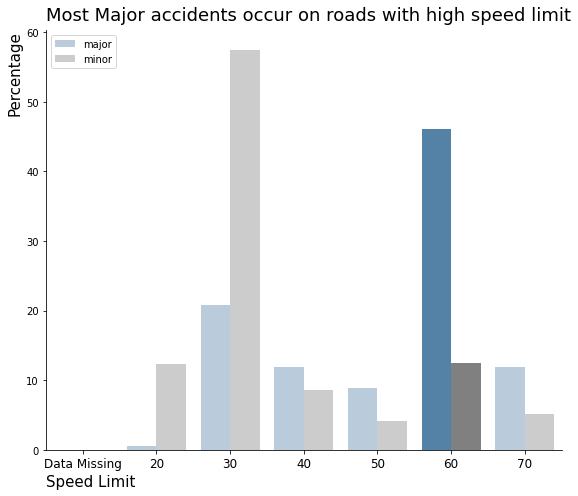

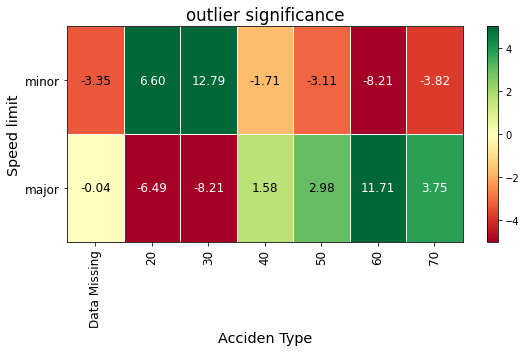

In [ ]:
data=pd.crosstab(accidents.label,accidents.speed_limit).apply(lambda r: r*100/r.sum(), axis=1)
data=data.stack().reset_index().rename(columns={0:'Percentage'})

label_df=lookup[lookup['field name']=='speed_limit'].set_index('code/format')
# label=[label_df[x] for  x in list(a_data['light_conditions'])]

fig, ax = plt.subplots(1,1, figsize=(8,7), sharey=True)

sns.barplot(x="speed_limit", y="Percentage", hue="label", data=data, alpha=0.4, palette=['steelblue', 'grey'])

labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0] = 'Data Missing'


# ax.set_title('{} accidents'.format(i[1]), fontdict={'fontsize' : 18}, loc='left', pad=10)
ax.set_xticklabels(labels, size=12,ha='center')  
ax.set_xlabel('Speed Limit',fontsize=15, loc='left')
ax.set_ylabel(ax.get_ylabel(),fontsize=15,loc='top')


# ax.containers[0]


ax.patches[5].set_alpha(1)
ax.patches[12].set_alpha(1)


ax.set_title('Most Major accidents occur on roads with high speed limit', fontdict={'fontsize' : 18}, loc='left', pad=10 )  
plt.legend(loc='upper left')
plt.tight_layout()
sns.despine()
plt.show()

###_________________________
x, y = accidents[['label', 'speed_limit']].T.values

phik.outlier_significance_from_array(x, y)

outlier_signifs = phik.outlier_significance_from_array(x, y)

label_df=lookup[lookup['field name']=='road_type'].set_index('code/format')

zvalues = outlier_signifs.values
xlabels = list(outlier_signifs.columns)
xlabels[0]='Data Missing'
ylabels = outlier_signifs.index
xlabel = 'Acciden Type'
ylabel = 'Speed limit'

plot_correlation_matrix(zvalues, x_labels=xlabels, y_labels=ylabels, 
                        x_label=xlabel,y_label=ylabel,
                        vmin=-5, vmax=5, title='outlier significance',
                        identity_layout=False, fontsize_factor=1.2, figsize=(8,5))

The speed limit has the highest association with major accidents. A high-speed limit indicates the increased probability of major accidents occurring. Based on the data, most of the major accidents (~50%) occurred on roads with a speed limit of 60 km/h

#### Urban or Rural

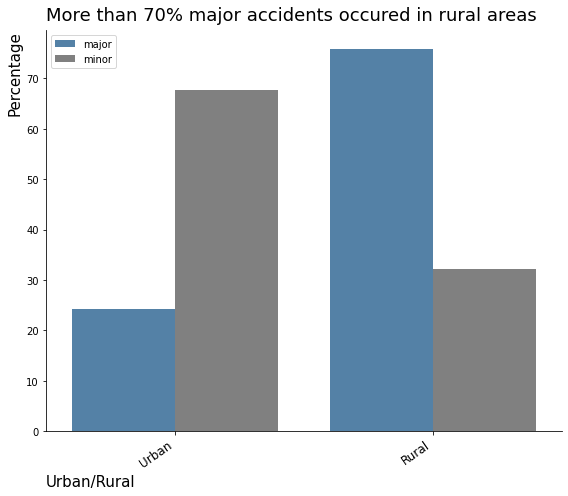

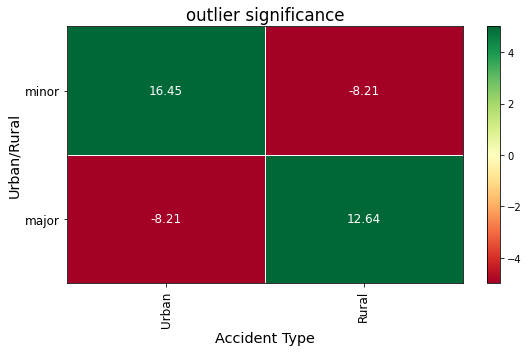

In [ ]:
data=pd.crosstab(accidents.label,accidents.urban_or_rural_area).apply(lambda r: r*100/r.sum(), axis=1)
data=data.stack().reset_index().rename(columns={0:'Percentage'})

label_df=lookup[lookup['field name']=='urban_or_rural_area'].set_index('code/format')
# label=[label_df[x] for  x in list(a_data['light_conditions'])]

fig, ax = plt.subplots(1,1, figsize=(8,7), sharey=True)

sns.barplot(x="urban_or_rural_area", y="Percentage", hue="label", data=data, palette=['steelblue', 'grey'])

label=[label_df.loc[str(x),'label'] for  x in [item.get_text() for item in ax.get_xticklabels()]]


# ax.set_title('{} accidents'.format(i[1]), fontdict={'fontsize' : 18}, loc='left', pad=10)
ax.set_xticklabels(label,rotation = 35, size=12,ha='right')  
ax.set_xlabel('Urban/Rural',fontsize=15, loc='left')
ax.set_ylabel(ax.get_ylabel(),fontsize=15,loc='top')


ax.set_title('More than 70% major accidents occured in rural areas', fontdict={'fontsize' : 18}, loc='left', pad=10 )  
ax.legend(loc='upper left')

plt.tight_layout()
sns.despine()
plt.show()

print('\n')

#_________________________

x, y = accidents[['label', 'urban_or_rural_area']].T.values

phik.outlier_significance_from_array(x, y)


outlier_signifs = phik.outlier_significance_from_array(x, y)

label_df=lookup[lookup['field name']=='urban_or_rural_area'].set_index('code/format')


zvalues = outlier_signifs.values
xlabels = [label_df.loc[str(x),'label'] for  x in list(outlier_signifs.columns)]
ylabels = outlier_signifs.index
xlabel = 'Accident Type'
ylabel = 'Urban/Rural'

plot_correlation_matrix(zvalues, x_labels=xlabels, y_labels=ylabels, 
                        x_label=xlabel,y_label=ylabel,
                        vmin=-5, vmax=5, title='outlier significance',
                        identity_layout=False, fontsize_factor=1.2, figsize=(8,5))

Usually, the majority of high-speed roads are outside of city limits. This finding explains that more than 70% of major accidents occur in rural areas.   

#### Number of cars involved in an accident

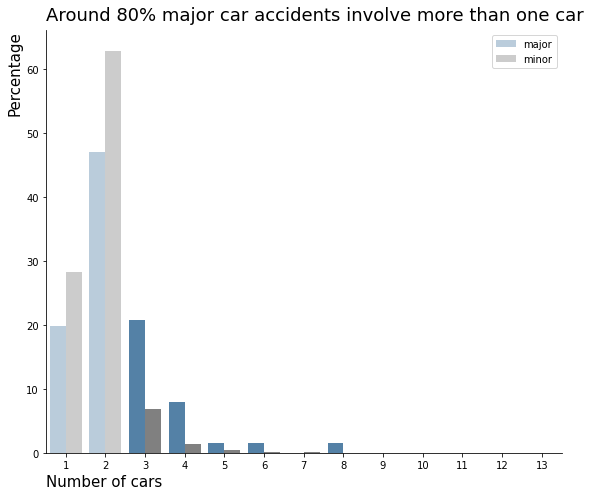

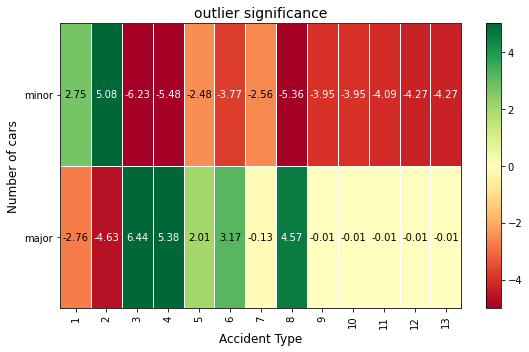

In [ ]:
data=pd.crosstab(accidents.label,accidents.number_of_vehicles).apply(lambda r: r*100/r.sum(), axis=1)
data=data.stack().reset_index().rename(columns={0:'Percentage'})

# label_df=lookup[lookup['field name']=='urban_or_rural_area'].set_index('code/format')
# label=[label_df[x] for  x in list(a_data['light_conditions'])]

fig, ax = plt.subplots(1,1, figsize=(8,7), sharey=True)

sns.barplot(x="number_of_vehicles", y="Percentage", hue="label", data=data, palette=['steelblue', 'grey'])

# label=[label_df.loc[str(x),'label'] for  x in [item.get_text() for item in ax.get_xticklabels()]]


# ax.set_title('{} accidents'.format(i[1]), fontdict={'fontsize' : 18}, loc='left', pad=10)
# ax.set_xticklabels(label,rotation = 35, size=12,ha='right')  
ax.set_xlabel('Number of cars',fontsize=15, loc='left')
ax.set_ylabel(ax.get_ylabel(),fontsize=15,loc='top')


# ax.containers[0]


ax.patches[0].set_alpha(0.4)
ax.patches[1].set_alpha(0.4)
ax.patches[13].set_alpha(0.4)
ax.patches[14].set_alpha(0.4)


ax.set_title('Around 80% major car accidents involve more than one car', fontdict={'fontsize' : 18}, loc='left', pad=10 )  
plt.legend(loc='upper right')
plt.tight_layout()
sns.despine()
plt.show()

###________________________________________________________

x, y = accidents[['label', 'number_of_vehicles_c']].T.values

phik.outlier_significance_from_array(x, y)

outlier_signifs = phik.outlier_significance_from_array(x, y)


# label_df=lookup[lookup['field name']=='junction_detail'].set_index('code/format')

zvalues = outlier_signifs.values
xlabels =   list(outlier_signifs.columns)
ylabels = outlier_signifs.index
xlabel = 'Accident Type'
ylabel = 'Number of cars'

plot_correlation_matrix(zvalues, x_labels=xlabels, y_labels=ylabels, 
                        x_label=xlabel,y_label=ylabel,
                        vmin=-5, vmax=5, title='outlier significance',
                        identity_layout=False, fontsize_factor=1, figsize=(8,5))

In high-speed roads, if one car gets into an accident, there is a high probability that following vehicles will also get into a difficult situation and will experience an accident in most cases. The main reason behind this situation is that they get very little reaction time.

This relationship is the opposite in low-speed roads. Following cars can get enough time to avoid accidents.

In the case of our analysis, we can observe that more than 80% of major accidents involve more than one car.


#### Light condition

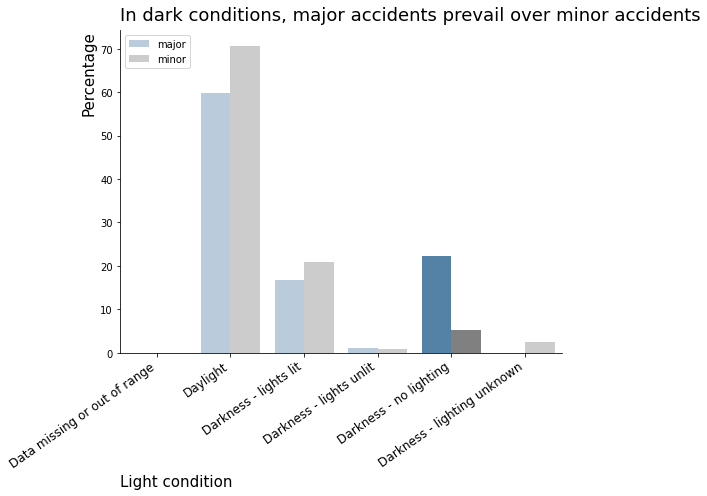

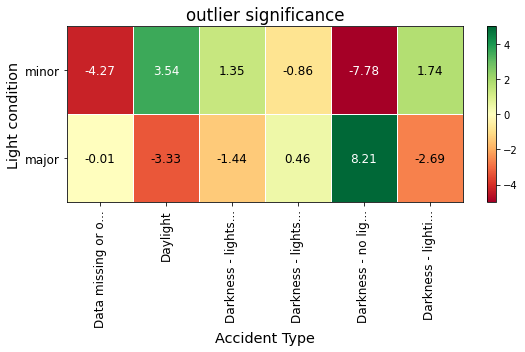

In [ ]:

data=pd.crosstab(accidents.label,accidents.light_conditions).apply(lambda r: r*100/r.sum(), axis=1)
data=data.stack().reset_index().rename(columns={0:'Percentage'})

label_df=lookup[lookup['field name']=='light_conditions'].set_index('code/format')
# label=[label_df[x] for  x in list(a_data['light_conditions'])]

fig, ax = plt.subplots(1,1, figsize=(8,7), sharey=True)

sns.barplot(x="light_conditions", y="Percentage", hue="label", data=data, alpha=0.4, palette=['steelblue', 'grey'])

label=[label_df.loc[str(x),'label'] for  x in [item.get_text() for item in ax.get_xticklabels()]]


# ax.set_title('{} accidents'.format(i[1]), fontdict={'fontsize' : 18}, loc='left', pad=10)
ax.set_xticklabels(label,rotation = 35, size=12,ha='right')  
ax.set_xlabel('Light condition',fontsize=15, loc='left')
ax.set_ylabel(ax.get_ylabel(),fontsize=15,loc='top')


# ax.containers[0]


ax.patches[4].set_alpha(1)
ax.patches[10].set_alpha(1)


ax.set_title('In dark conditions, major accidents prevail over minor accidents', fontdict={'fontsize' : 18}, loc='left', pad=10 )  
plt.legend(loc='upper left')
plt.tight_layout()
sns.despine()
plt.show()
###________________________________________________
x, y = accidents[['label', 'light_conditions']].T.values

phik.outlier_significance_from_array(x, y)

outlier_signifs = phik.outlier_significance_from_array(x, y)

label_df=lookup[lookup['field name']=='light_conditions'].set_index('code/format')

zvalues = outlier_signifs.values
xlabels = [label_df.loc[str(x),'label'] for  x in list(outlier_signifs.columns)]
ylabels = outlier_signifs.index
xlabel = 'Accident Type'
ylabel = 'Light condition'

plot_correlation_matrix(zvalues, x_labels=xlabels, y_labels=ylabels, 
                        x_label=xlabel,y_label=ylabel,
                        vmin=-5, vmax=5, title='outlier significance',
                        identity_layout=False, fontsize_factor=1.2, figsize=(8,5))

In dark conditions, there is a probability of an accident turning into a major accident. Our analysis shows that dark conditions have more outlier significance with major accidents than minor accidents.

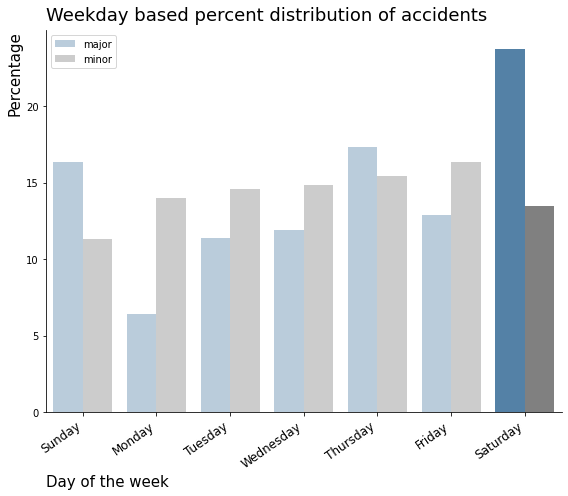

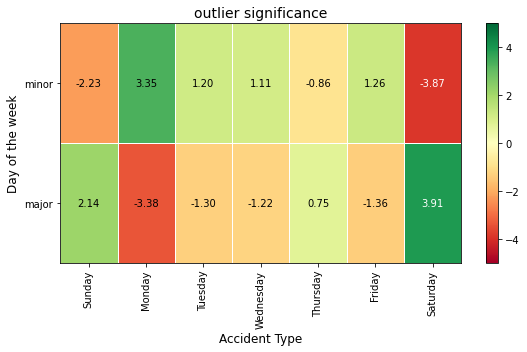

In [ ]:
data=pd.crosstab(accidents.label,accidents.day_of_week_c).apply(lambda r: r*100/r.sum(), axis=1)
data=data.stack().reset_index().rename(columns={0:'Percentage'})

label_df=lookup[lookup['field name']=='day_of_week'].set_index('code/format')
# label=[label_df[x] for  x in list(a_data['light_conditions'])]

fig, ax = plt.subplots(1,1, figsize=(8,7), sharey=True)

sns.barplot(x="day_of_week_c", y="Percentage", hue="label", data=data, palette=['steelblue', 'grey'], alpha=0.4)

label=[label_df.loc[str(x),'label'] for  x in [item.get_text() for item in ax.get_xticklabels()]]


# ax.set_title('{} accidents'.format(i[1]), fontdict={'fontsize' : 18}, loc='left', pad=10)
ax.set_xticklabels(label,rotation = 35, size=12,ha='right')  
ax.set_xlabel('Day of the week',fontsize=15, loc='left')
ax.set_ylabel(ax.get_ylabel(),fontsize=15,loc='top')

ax.patches[6].set_alpha(1)
ax.patches[13].set_alpha(1)


ax.set_title('Weekday based percent distribution of accidents', fontdict={'fontsize' : 18}, loc='left', pad=10 )  
ax.legend(loc='upper left')

plt.tight_layout()
sns.despine()
plt.show()

#______________________________________________________________________
x, y = accidents[['label', 'day_of_week_c']].T.values

phik.outlier_significance_from_array(x, y)

outlier_signifs = phik.outlier_significance_from_array(x, y)


label_df=lookup[lookup['field name']=='day_of_week'].set_index('code/format')

zvalues = outlier_signifs.values
xlabels =  [label_df.loc[str(x),'label'] for  x in list(outlier_signifs.columns)]
ylabels = outlier_signifs.index
xlabel = 'Accident Type'
ylabel = 'Day of the week'

plot_correlation_matrix(zvalues, x_labels=xlabels, y_labels=ylabels, 
                        x_label=xlabel,y_label=ylabel,
                        vmin=-5, vmax=5, title='outlier significance',
                        identity_layout=False, fontsize_factor=1, figsize=(8,5))

As observed in the EDA section, most major accidents occur during weekends. The probable reason may be intoxication or people being more relaxed and carefree during these days.

#### Road type

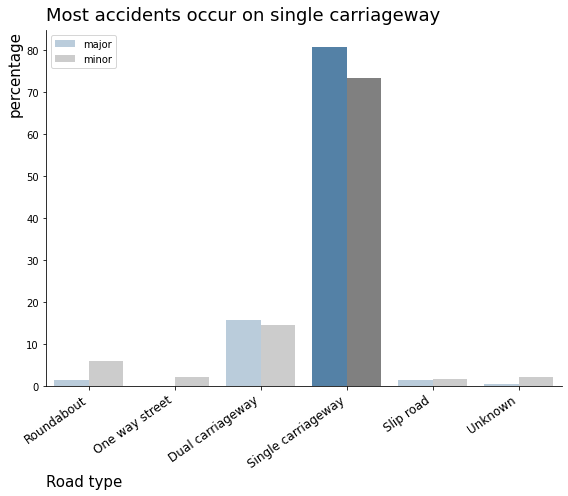

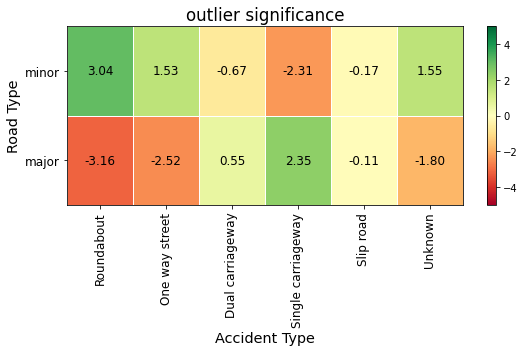

In [ ]:
data=pd.crosstab(accidents.label,accidents.road_type).apply(lambda r: r*100/r.sum(), axis=1)
data=data.stack().reset_index().rename(columns={0:'percentage'})

label_df=lookup[lookup['field name']=='road_type'].set_index('code/format')
# label=[label_df[x] for  x in list(a_data['light_conditions'])]

fig, ax = plt.subplots(1,1, figsize=(8,7), sharey=True)

sns.barplot(x="road_type", y="percentage", hue="label", data=data, alpha=0.4, palette=['steelblue', 'grey'])

label=[label_df.loc[str(x),'label'] for  x in [item.get_text() for item in ax.get_xticklabels()]]


# ax.set_title('{} accidents'.format(i[1]), fontdict={'fontsize' : 18}, loc='left', pad=10)
ax.set_xticklabels(label,rotation = 35, size=12,ha='right')  
ax.set_xlabel('Road type',fontsize=15, loc='left')
ax.set_ylabel(ax.get_ylabel(),fontsize=15,loc='top')


# ax.containers[0]


ax.patches[3].set_alpha(1)
ax.patches[9].set_alpha(1)


ax.set_title('Most accidents occur on single carriageway', fontdict={'fontsize' : 18}, loc='left', pad=10 )  
ax.legend(loc='upper left')

plt.tight_layout()
sns.despine()
plt.show()


###_________________________
x, y = accidents[['label', 'road_type']].T.values

phik.outlier_significance_from_array(x, y)

outlier_signifs = phik.outlier_significance_from_array(x, y)

label_df=lookup[lookup['field name']=='road_type'].set_index('code/format')

zvalues = outlier_signifs.values
xlabels = [label_df.loc[str(x),'label'] for  x in list(outlier_signifs.columns)]
ylabels = outlier_signifs.index
xlabel = 'Accident Type'
ylabel = 'Road Type'

plot_correlation_matrix(zvalues, x_labels=xlabels, y_labels=ylabels, 
                        x_label=xlabel,y_label=ylabel,
                        vmin=-5, vmax=5, title='outlier significance',
                        identity_layout=False, fontsize_factor=1.2, figsize=(8,5))

A single-carriageway is a road with one or more lanes no divider to separate opposing traffic flows. This type of road can be hazardous as they increase the risk of head-to-head collision, ALthough the accident type percentages for both accident types are higher for this type of road.

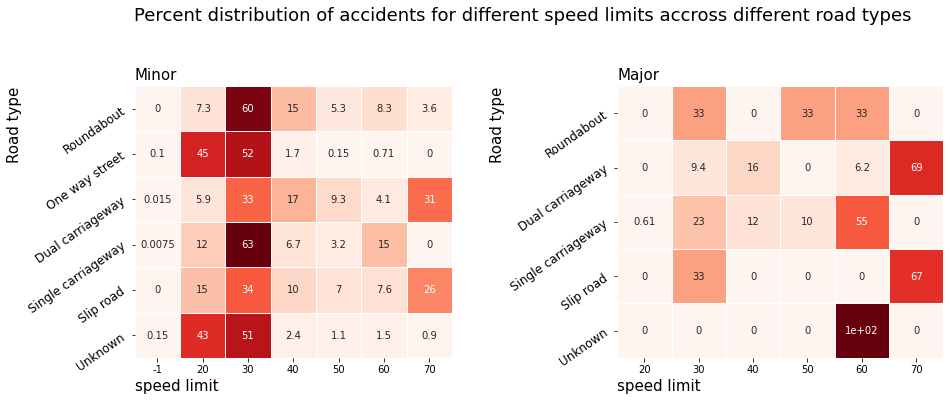

In [ ]:
kk=pd.crosstab(minor.road_type,minor.speed_limit, normalize='index')*100

fig, ax = plt.subplots(1,2,figsize=(16,5))
sns.heatmap(kk, 
            cmap='Reds',
            annot=True, 
            linewidths=1, 
            square=True,
           cbar=False, ax=ax[0])

label_df=lookup[lookup['field name']=='road_type'].set_index('code/format')
ylabels = [label_df.loc[str(x),'label'] for  x in list(kk.index)]

ax[0].set_title('Minor',fontsize=15,loc='left')
ax[0].set_yticklabels(ylabels,rotation = 35, size=12,ha='right')
ax[0].set_xlabel('speed limit',fontsize=15,loc='left')
ax[0].set_ylabel('Road type',fontsize=15,loc='top')

#____

pp=pd.crosstab(major.road_type,major.speed_limit, normalize='index')*100

sns.heatmap(pp, 
            cmap='Reds',
            annot=True, 
            linewidths=1, 
            square=True,
           cbar=False, ax=ax[1])

ylabels_1 = [label_df.loc[str(x),'label'] for  x in list(pp.index)]

ax[1].set_title('Major',fontsize=15,loc='left')
ax[1].set_yticklabels(ylabels_1,rotation = 35, size=12,ha='right')
ax[1].set_xlabel('speed limit',fontsize=15,loc='left')
ax[1].set_ylabel('Road type',fontsize=15,loc='top')

plt.suptitle('Percent distribution of accidents for different speed limits accross different road types', size=18, y=1.1)
plt.show()

After plotting the percent distribution of different speed limits for each road type, we can see that most major accidents occur at Single carriageways with high-speed limits. In contrast, minor accidents occur on roads with low-speed limits. So, we can see that Single carriageways with high-speed limits can become a deadly combination.


__##Note :__

We skipped several features ( junction_control, junction_detail,first_road_class and pedestrian_crossing_physical_facilities) before road type despite having higher correlation compared to road type. It is because road-type features can mostly explain these features. High-speed Single carriageways usually run for a long distance without any junction and pedestrian crossing. So, for most major accidents, these features have no value or value is out of range, and for that reason, they yield a very high association.

This reason is also applicable for pedestrian_crossing_human_control and second_road_class features.


#### Road Surface condition

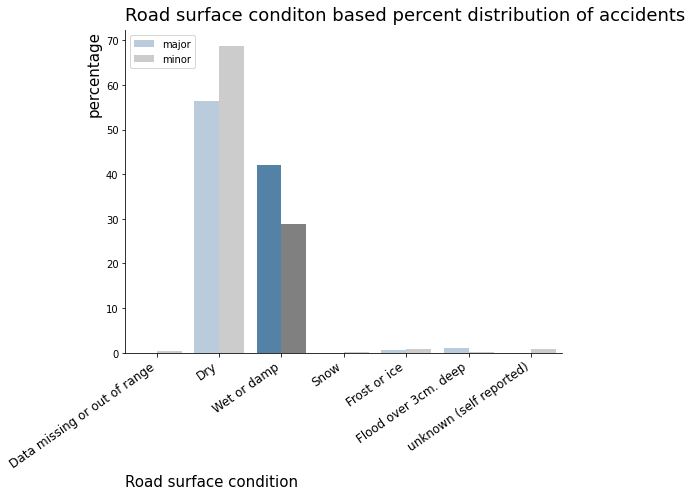

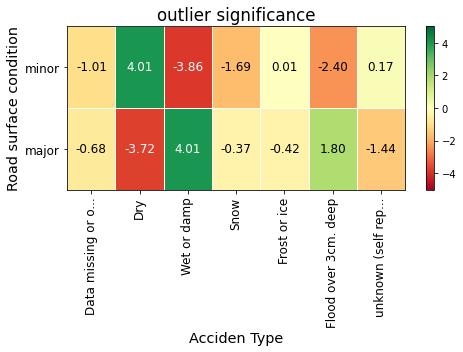

In [ ]:
data=pd.crosstab(accidents.label,accidents.road_surface_conditions).apply(lambda r: r*100/r.sum(), axis=1)
data=data.stack().reset_index().rename(columns={0:'percentage'})

label_df=lookup[lookup['field name']=='road_surface_conditions'].set_index('code/format')
# label=[label_df[x] for  x in list(a_data['light_conditions'])]

fig, ax = plt.subplots(1,1, figsize=(8,7), sharey=True)

sns.barplot(x="road_surface_conditions", y="percentage", hue="label", data=data, alpha=0.4, palette=['steelblue', 'grey'])

label=[label_df.loc[str(x),'label'] for  x in [item.get_text() for item in ax.get_xticklabels()]]


# ax.set_title('{} accidents'.format(i[1]), fontdict={'fontsize' : 18}, loc='left', pad=10)
ax.set_xticklabels(label,rotation = 35, size=12,ha='right')  
ax.set_xlabel('Road surface condition',fontsize=15, loc='left')
ax.set_ylabel(ax.get_ylabel(),fontsize=15,loc='top')


# ax.containers[0]


ax.patches[2].set_alpha(1)
ax.patches[9].set_alpha(1)


ax.set_title('Road surface conditon based percent distribution of accidents', fontdict={'fontsize' : 18}, loc='left', pad=10 )  
plt.legend(loc='upper left')
plt.tight_layout()
sns.despine()
plt.show()
#__________________________
x, y = accidents[['label', 'road_surface_conditions']].T.values

phik.outlier_significance_from_array(x, y)

outlier_signifs = phik.outlier_significance_from_array(x, y)

label_df=lookup[lookup['field name']=='road_surface_conditions'].set_index('code/format')

zvalues = outlier_signifs.values
xlabels = [label_df.loc[str(x),'label'] for  x in list(outlier_signifs.columns)]
ylabels = outlier_signifs.index
xlabel = 'Acciden Type'
ylabel = 'Road surface condition'

plot_correlation_matrix(zvalues, x_labels=xlabels, y_labels=ylabels, 
                        x_label=xlabel,y_label=ylabel,
                        vmin=-5, vmax=5, title='outlier significance',
                        identity_layout=False, fontsize_factor=1.2)

The wet/damp condition makes roads slippery and can increase the probability of significant accidents. Our analysis reveals that wet/damp road surface conditions are highly associated with major types of accidents.

#### Carriageway hazards

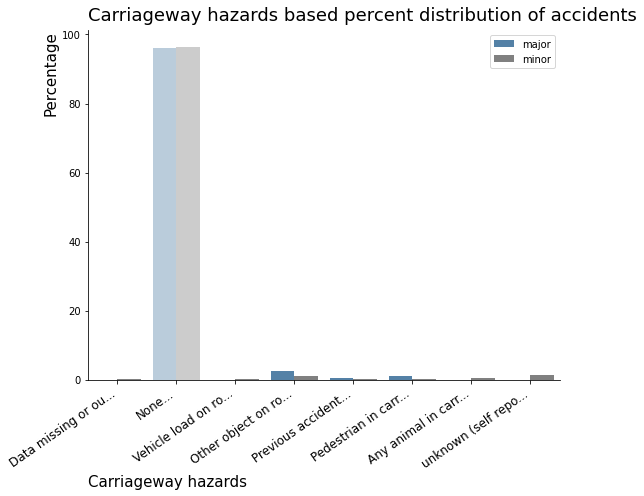

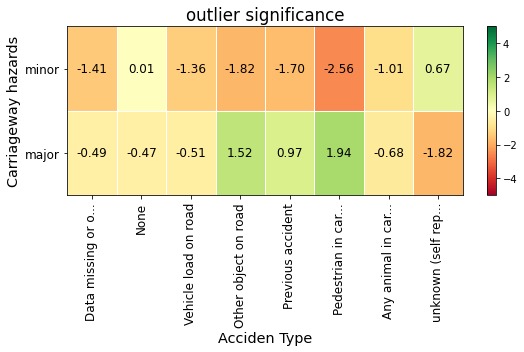

In [ ]:
data=pd.crosstab(accidents.label,accidents.carriageway_hazards).apply(lambda r: r*100/r.sum(), axis=1)
data=data.stack().reset_index().rename(columns={0:'Percentage'})

label_df=lookup[lookup['field name']=='carriageway_hazards'].set_index('code/format')
# label=[label_df[x] for  x in list(a_data['light_conditions'])]

fig, ax = plt.subplots(1,1, figsize=(8,7), sharey=True)

sns.barplot(x="carriageway_hazards", y="Percentage", hue="label", data=data, palette=['steelblue', 'grey'])

labels = [label_df.loc[str(x),'label'] for  x in [item.get_text() for item in ax.get_xticklabels()]]
# labels[0] = 'Data Missing'
labels =   [x[:18]+'...' for x in labels]

# ax.set_title('{} accidents'.format(i[1]), fontdict={'fontsize' : 18}, loc='left', pad=10)

# ax.set_xticklabels(label,rotation = 35, size=12,ha='right')  
# ax.set_xlabel('Road type',fontsize=15, loc='left')
# ax.set_ylabel(ax.get_ylabel(),fontsize=15,loc='top')

ax.set_xticklabels(labels, size=12, rotation=35,ha='right',)  
ax.set_xlabel('Carriageway hazards ',fontsize=15, loc='left')
ax.set_ylabel(ax.get_ylabel(),fontsize=15,loc='top')

ax.patches[1].set_alpha(0.4)
ax.patches[9].set_alpha(0.4)


ax.set_title('Carriageway hazards based percent distribution of accidents', fontdict={'fontsize' : 18}, loc='left', pad=10 )  
plt.legend(loc='upper right')
plt.tight_layout()
sns.despine()
plt.show()


#_________________
x, y = accidents[['label', 'carriageway_hazards']].T.values

phik.outlier_significance_from_array(x, y)

outlier_signifs = phik.outlier_significance_from_array(x, y)

label_df=lookup[lookup['field name']=='carriageway_hazards'].set_index('code/format')

zvalues = outlier_signifs.values
xlabels = [label_df.loc[str(x),'label'] for  x in list(outlier_signifs.columns)]
ylabels = outlier_signifs.index
xlabel = 'Acciden Type'
ylabel = 'Carriageway hazards'

plot_correlation_matrix(zvalues, x_labels=xlabels, y_labels=ylabels, 
                        x_label=xlabel,y_label=ylabel,
                        vmin=-5, vmax=5, title='outlier significance',
                        identity_layout=False, fontsize_factor=1.2, figsize=(8,5))

Although carriageway hazards are infrequent, such hazards can increase the probability of major accidents.

## Recommendation 

As per the findings of our analysis, we recommend the following measures that can be implemented  as preventive measures to reduce the number of accidents in upcoming years,
-	The government can enforce stricter speed-limit violation-related laws in major accident-prone roads, specifically single-carriageways. Like,
o	Presence of more highway police
o	They can place more speed-limit signs, cautionary signs, and violation consequence-related signs.
o	More CCTV cameras can be installed to monitor driver behavior.
o	Reevaluate the laws and regulations. Introduce more strict rules and harder punishment.
-	Reevaluate the speed limit for accident-prone roads.
-	Identify roads with no or little lighting and place more lights.
-	Placing road dividers on major accident-prone roads
-	Identify roads that stay wet/damp for a more extended period and install cautionary signs before such regions.
-	Increase the presence of highway police during rush hours and on weekends.
-	Introduce campaigns to educate the general population about standard features of major accidents and how to act if someone faces such situations.
-	Encourage prompt reporting of carriageway hazards and implement measures for their earliest removal from the roads. 
Also, we would recommend collecting further accident-related information that can help us identify more accident-causing factors. Like,
-	Driver's previous driving history (prior accidents, violations, and intoxication records)
-	Identify whether the driver was using hand-held devices during the accident.
-	Vehicle age and vehicle condition data

We want to mention that the availability of historical data will help us conduct further analysis, which may identify more pertinent facts regarding different types of accidents. Due to the extreme class imbalance of the dependent variable, applying any machine learning approach was pointless. They will blindly predict the class with the most observations and yield a high accuracy score.  The inclusion of historical data may mitigate this problem. 


### Citations

- A new correlation coefficient between categorical, ordinal and interval variables with Pearson characteristics. M.Baak. https://doi.org/10.1016/j.csda.2020.107043
- The Search for Categorical Correlation. https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
- Mapping the UK’s Traffic Accident Hotspots. https://towardsdatascience.com/mapping-the-uks-traffic-accident-hotspots-632b1129057b


